# Verifying generalizability


In [2]:
%cd /home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1


In [47]:
from src.util import read_results, train_test_validate_split, eval_result, eval_sota_models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
result_df = read_results()
_, test, validate = train_test_validate_split(read_results())

train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39406/171547 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '1080' 'CPU 16c' 'CPU 08c' 'v100' '2080' 'a40' 'p100']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 17014/73395 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['2080' '1080' 'CPU 16c' 'a40' 'v100' 'CPU 08c' 'CPU 32c' 'p100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [61]:
rdf = result_df.loc[validate.index]
rdf[(rdf.dataset_type == 'synthetic') & (rdf.compute_unit != 'p100')]

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,compute_unit,complexity_ratio,...,gpu_clock_speed_max_boost,gpu_memory_bus_width,gpu_memory_size,gpu_memory_clock,gpu_memory_bandwidth,gpu_processing_power_half_precision,gpu_processing_power_single_precision,gpu_processing_power_double_precision,materialized_times_mean,time_saved


In [62]:

results = {}

file_to_name = {
    "STAT1_label.csv": "STAT.1",
    "STAT5_label.csv": "STAT.5",
    "XGB3_label.csv": "XGB.3",
    "XGB5_label.csv": "XGB.5",
    
}
for eval_type in ["new hardware", "real datasets", "full"]:
    val_df = result_df.loc[validate.index]
    if eval_type == "full":
        loc = val_df.index
    elif eval_type == "new hardware":
        loc = val_df[val_df.compute_unit == 'p100'].index
    else:
        loc = val_df[val_df.dataset_type != 'synthetic'].index
    y_true = validate.label.loc[loc]
    full_dataset = validate.loc[loc]
    
    results.update({(name, eval_type): val for (name, val) in eval_sota_models(full_dataset, y_true, full_dataset).items()})
    
    for f in glob.glob("evaluation/predictions/*_label.csv"):
        df = pd.read_csv(f, index_col= 0)
        assert len(validate.index) == len(set(validate.index).intersection(df.index))
        print([col for col in df.columns if 'y_pred' in col])
        y_pred = df[[col for col in df.columns if 'y_pred' in col][0]]
        name = file_to_name[f.split('/')[-1]]
        results[(name, eval_type)] = eval_result(y_true, y_pred.loc[loc], target_col='label', full_dataset=full_dataset)[0]
results.keys()

2024-03-25 16:51:38.530 | INFO     | src.util:eval_model:472 - Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'complexity_ratio', 'times_mean',
       'compute_type', 'label', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'spa

['stat_y_pred']
['xgb_y_pred_time_saved']
['xgb_y_pred_speedup']
['stat_y_pred']
['stat_y_pred']


2024-03-25 16:51:38.983 | INFO     | src.util:eval_model:472 - Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'complexity_ratio', 'times_mean',
       'compute_type', 'label', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'spa

['xgb_y_pred_time_saved']
['xgb_y_pred_speedup']
['stat_y_pred']


2024-03-25 16:51:39.156 | INFO     | src.util:eval_model:475 - Score: 0.25663716814159293


['stat_y_pred']
['xgb_y_pred_time_saved']
['xgb_y_pred_speedup']
['stat_y_pred']


dict_keys([('MorpheusFI', 'new hardware'), ('Morpheus', 'new hardware'), ('Amalur', 'new hardware'), ('STAT.1', 'new hardware'), ('XGB.5', 'new hardware'), ('XGB.3', 'new hardware'), ('STAT.5', 'new hardware'), ('MorpheusFI', 'real datasets'), ('Morpheus', 'real datasets'), ('Amalur', 'real datasets'), ('STAT.1', 'real datasets'), ('XGB.5', 'real datasets'), ('XGB.3', 'real datasets'), ('STAT.5', 'real datasets'), ('MorpheusFI', 'full'), ('Morpheus', 'full'), ('Amalur', 'full'), ('STAT.1', 'full'), ('XGB.5', 'full'), ('XGB.3', 'full'), ('STAT.5', 'full')])

In [38]:
eval_results = pd.DataFrame(results).T
merged_results = (
    eval_results.reset_index(names=["model", "eval_type"])
    .merge(pd.json_normalize(eval_results.speedup), left_index=True, right_index=True)
    .drop(columns="speedup")
).sort_values(['model', 'eval_type'])
merged_results['fraction_of_optimal_performance'] =  merged_results.y_pred_time_saved / merged_results.y_true_time_saved
merged_results['model_type'] = merged_results.model.str.contains('.', regex=False).replace({True: 'own', False: 'SOTA'})
merged_results

,model,eval_type,accuracy,precision,recall,f1,y_true_mat_time,y_true_fact_time,y_true_best_time,y_true_time_saved,...,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_performance,model_type
16,Amalur,full,0.743363,0.128401,0.268923,0.173813,2792.661281,1125.213199,1125.213199,1667.448082,...,1191.483038,-507.350463,0.894552,0.762470,"(302, 3.4123536322426995)","(2050, 0.5236365896605994)","(8014, 0.3389793863528731)","(821, 4.2392536973143775)",-0.304268,SOTA
9,Amalur,new datasets,0.652914,0.671875,0.389728,0.493308,1895.431467,804.295675,804.295675,1091.135792,...,332.248282,301.676473,2.721876,1.651230,"(258, 3.772472326329065)","(126, 0.5706541747294778)","(739, 0.6215475166453209)","(404, 5.881286444626252)",0.276479,SOTA
2,Amalur,new hardware,0.752671,0.043155,0.147708,0.066795,1408.911454,472.685621,472.685621,936.225833,...,893.265095,-676.176203,0.610594,0.603862,"(87, 2.584206354159701)","(1929, 0.5215815128061159)","(7311, 0.31236672296037205)","(502, 3.4546332294332616)",-0.722236,SOTA
15,Morpheus,full,0.308572,0.065457,0.443455,0.114076,2792.661281,1125.213199,1125.213199,1667.448082,...,3216.534526,-6708.354153,0.505625,0.365334,"(498, 2.5668388611834354)","(7110, 0.3612535256520043)","(2954, 0.4135149775390669)","(625, 5.172275727300878)",-4.023126,SOTA
8,Morpheus,new datasets,0.588736,0.559028,0.243202,0.338947,1895.431467,804.295675,804.295675,1091.135792,...,369.821568,92.929285,2.256180,1.148341,"(161, 3.5884141741026476)","(127, 0.5672856408388689)","(738, 0.6221961577645935)","(501, 5.532141520541672)",0.085167,SOTA
1,Morpheus,new hardware,0.267169,0.050435,0.629881,0.093392,1408.911454,472.685621,472.685621,936.225833,...,2884.934398,-6679.622045,0.451173,0.330814,"(371, 2.2116919019551227)","(6985, 0.3576650981051124)","(2255, 0.35102134789448713)","(218, 5.22254191909193)",-7.134627,SOTA
14,MorpheusFI,full,0.09806,0.095753,0.945681,0.173899,2792.661281,1125.213199,1125.213199,1667.448082,...,11402.449098,-13733.249023,0.732680,0.486830,"(1062, 4.098247872408922)","(10029, 0.37629006778891655)","(35, 0.4635063194603)","(61, 2.6003088841659823)",-8.236088,SOTA
7,MorpheusFI,new datasets,0.416503,0.419986,0.907855,0.574295,1895.431467,804.295675,804.295675,1091.135792,...,7565.970170,-4618.043037,2.589603,0.651037,"(601, 5.309016209463859)","(830, 0.6204859272719228)","(35, 0.4635063194603)","(61, 2.6003088841659823)",-4.232327,SOTA
0,MorpheusFI,new hardware,0.058704,0.058776,0.979626,0.110898,1408.911454,472.685621,472.685621,936.225833,...,4282.279116,-8897.156814,0.530243,0.368953,"(577, 3.3198505631577966)","(9240, 0.3560437066846622)","(0, nan)","(12, 3.624838253778563)",-9.503217,SOTA
17,STAT.1,full,0.914186,0.635158,0.341051,0.443801,2792.661281,1125.213199,1125.213199,1667.448082,...,655.472087,476.671673,2.694903,1.508993,"(383, 3.892637893961572)","(220, 0.6097564602285727)","(9844, 0.3713825060733308)","(740, 4.0811861743852935)",0.285869,own


In [63]:
pd.Series({
    "XGB.3": 0.955262,
    "XGB.5": 0.928276,
    "STAT.1": 0.253900,
    "STAT.5": 0.301963,
})

XGB.3     0.955262
XGB.5     0.928276
STAT.1    0.253900
STAT.5    0.301963
dtype: float64

In [82]:
test_set_fraction_of_optimal_performance = pd.Series({
    "XGB.3": 0.955262,
    "XGB.5": 0.928276,
    "STAT.1": 0.253900,
    "STAT.5": 0.301963,
})
merged_results['test_set_fraction_of_optimal_performance'] = merged_results.model.map(test_set_fraction_of_optimal_performance)
merged_results['performance_pct_vs_baseline'] = merged_results.fraction_of_optimal_performance / merged_results.test_set_fraction_of_optimal_performance * 100

## New (real) datasets
Show performance loss

In [161]:
palette= sns.color_palette("rocket", len(merged_results.model.unique()))

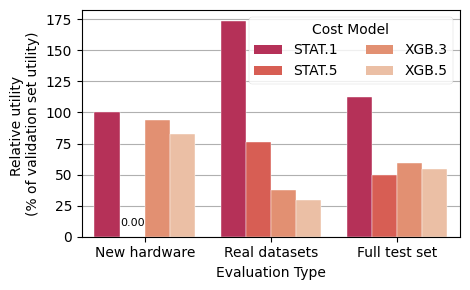

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(0.6 * 8, 3))
plotdf = merged_results[merged_results.model_type == "own"].sort_values("eval_type", ascending=False)
sns.barplot(data=plotdf, y="performance_pct_vs_baseline", x="eval_type", hue="model", ax=ax, palette=palette[3:])
ax.grid(axis="y")
ax.set_axisbelow(True)
# ax.set_ylim(0., 1.)
ax.legend(title="Cost Model", ncol=2)
ax.set_ylabel("Relative utility \n(% of validation set utility)")
ax.set_xlabel("Evaluation Type")
ax.set_xticklabels(["New hardware", "Real datasets", "Full test set"])

for patch in ax.patches:
    patch.set_edgecolor("white")
    if patch.get_height() < 0.1:
        ax.annotate(
            f"{patch.get_height():.2f}",
            (patch.get_x() + patch.get_width() / 2.0, patch.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
            fontsize=8,
            color="black",
            rotation=0,
        )
fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/06_evaluation/figures/eval_generalization.pdf", bbox_inches="tight")

## SOTA comparison

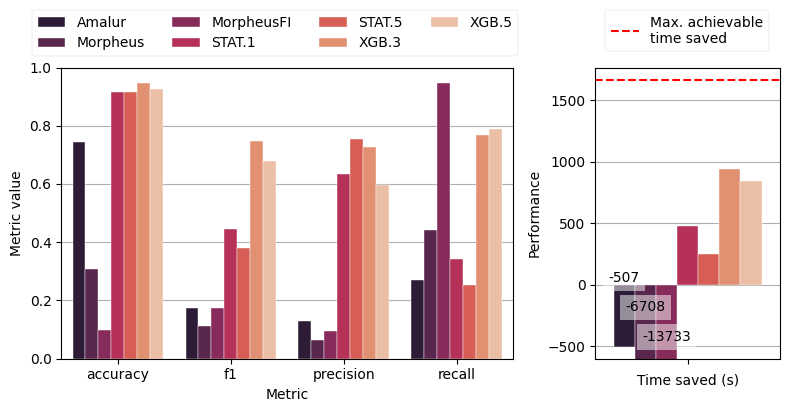

In [175]:
# colors = []
# for c in sns.color_palette("rocket_r", 6):
#     colors.extend([
#                    sns.set_hls_values(c, l=0.4),
#                    c])
# colors.pop(1)

fig, axs = plt.subplot_mosaic("AAB", figsize=(8, 3.7))
melted_df = pd.melt(merged_results, id_vars=["model", "eval_type"], var_name="metric", value_name="metric_value").sort_values(by="model")
max_time_saved = merged_results.y_true_time_saved.max()
min_ylim = -600
def plot_metrics(ax, metrics: list, legend=True):
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    ax = sns.barplot(
        data=melted_df[(melted_df.metric.apply(lambda x: x in metrics)) & (melted_df.eval_type=='full')],
        x="metric",
        y="metric_value",
        hue="model",
        palette=palette,
        ax=ax,
    )
    if not legend:
        ax.get_legend().remove()
    else:
        legend = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 1.1), ncol=5, borderaxespad=-1)
    # Add metric values as text on top of every bar
    for i, p in enumerate(ax.patches):
        p.set_edgecolor("white")
        fmt = ".2f" if abs(p.get_height()) < 1 else ".0f"
        height = p.get_height()
        if height <( min_ylim+100):
            ax.annotate(
                format(p.get_height(),fmt),
                (p.get_x() + p.get_width() / 2.0, 120*i*-2),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
                bbox={"facecolor": "white", "alpha": 0.5, "edgecolor": "none"},
            )
    return legend

ax_left = axs["A"]
ax_right = axs["B"]
plot_metrics(ax_left, ["accuracy", "precision", "recall", "f1"], legend=False)
plot_metrics(ax_right, ["y_pred_time_saved"], legend=True)

ax_left.set_xlabel("Metric")
ax_left.set_ylabel("Metric value" )
ax_left.set_ylim(0., 1.)

ax_right.axhline(max_time_saved, ls="--", color="red", label="Max. achievable\ntime saved",)
ax_right.set_ylim(min_ylim, max_time_saved+100)
ax_right.set_xlabel("Time saved (s)")
ax_right.set_ylabel("Performance")
ax_right.set_xticklabels(labels=[None])

handles, labels = ax_right.get_legend_handles_labels()
l1 = fig.legend(handles[1:], labels[1:], ncols=4, loc="upper center", bbox_to_anchor=(0.35, 1.1), borderaxespad=0)
ax_right.legend().remove()
l2 = fig.legend([handles[0]], [labels[0]], loc="upper center", bbox_to_anchor=(0.865, 1.1), borderaxespad=0)

fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/06_evaluation/figures/eval_sota_results.pdf", bbox_inches="tight")